In [1]:
from tqdm import tqdm
from workflow.fastani.remove_gunc_failed_contigs_by_contamination_sp_cluster import RemoveGuncFailedContigsByContaminationSpCluster
from workflow.config import PCT_VALUES
from workflow.external.gtdb_metadata import GtdbMetadataR207Full

In [2]:
DF = RemoveGuncFailedContigsByContaminationSpCluster().output().read_cached()
print(DF.shape)

UNQ_GIDS = set(DF.index.get_level_values(0))

print(f'{len(UNQ_GIDS):,} failed gids')
DF.head()

(578539, 5)
35,723 failed gids


new_sp_rep      ani        af    type  same
gid             pct                                                  
GCA_000143435.1 1    GCF_001435955.1  97.3270  0.875591  sp_rep  True
                5    GCF_001435955.1  97.3270  0.875591  sp_rep  True
                15   GCF_001435955.1  97.6349  0.829228  sp_rep  True
GCA_000153745.1 5                NaN      NaN       NaN  no_ani  True
GCA_000155005.1 1    GCF_003697165.2  96.5203  0.827668  sp_rep  True

In [3]:
DF_META = GtdbMetadataR207Full().output().read_cached()
DF_META.head()

,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,contig_count,...,trna_aa_count,trna_count,trna_selenocysteine_count,domain,phylum,class,order,family,genus,species
gid,,,,,,,,,,,,,,,,,,,,,
GCA_000006155.2,1916,93.12,0.0,1171,g__Bacillus (UID902),324,0.0,4305660,80.178992,426,...,16,31,0,d__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales,f__Bacillaceae_G,g__Bacillus_A,s__Bacillus_A anthracis
GCA_000007325.1,1,99.95,0.0,149,k__Bacteria (UID2329),89,0.0,1973459,90.754610,1,...,20,47,0,d__Bacteria,p__Fusobacteriota,c__Fusobacteriia,o__Fusobacteriales,f__Fusobacteriaceae,g__Fusobacterium,s__Fusobacterium nucleatum
GCA_000007385.1,0,99.82,0.0,481,c__Gammaproteobacteria (UID4202),276,0.0,4190634,84.805944,1,...,20,53,0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Xanthomonadales,f__Xanthomonadaceae,g__Xanthomonas,s__Xanthomonas oryzae
GCA_000008085.1,0,73.13,0.0,149,k__Archaea (UID2),107,0.0,462902,94.299480,1,...,17,38,0,d__Archaea,p__Nanoarchaeota,c__Nanoarchaeia,o__Nanoarchaeales,f__Nanoarchaeaceae,g__Nanoarchaeum,s__Nanoarchaeum equitans
GCA_000008885.1,0,100.00,0.0,134,k__Bacteria (UID2495),80,0.0,617456,87.831079,2,...,20,34,0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales_A,f__Enterobacteriaceae_A,g__Wigglesworthia,s__Wigglesworthia glossinidia_A


types:
no_af = no alignment fraction <0.5
no_ani = novel species cluster
sp_rep = found species representative within ANI radius


In [4]:

def get_cutoff_at_which_sp_cluster_changed():

    df_changed = DF[DF['same'] == False]

    print(df_changed.shape)
    print(df_changed.head())

    cutoff_vals = list()
    gids = list()
    gids_seen = set()
    types = list()
    new_sp_rep = list()

    print('gid\tcutoff\ttype\tnew_sp_rep\tprev_sp\tis_sp_rep')
    for (gid, pct), row in df_changed.iterrows():
        if gid in gids_seen:
            continue
        gids_seen.add(gid)
        gids.append(gid)

        cutoff_vals.append(pct)
        types.append(row['type'])
        new_sp_rep.append(row['new_sp_rep'])

        cur_gid = gid
        cur_cutoff = pct
        cur_type = row['type']
        cur_new_sp_rep = row['new_sp_rep']

        meta_row = DF_META.loc[cur_gid]
        expected_sp = meta_row['species']
        is_sp_rep = meta_row['gtdb_representative'] == 't'


        print(f'{cur_gid}\t{cur_cutoff}\t({cur_type})\t{cur_new_sp_rep}\t{expected_sp}\t{is_sp_rep}')

    print(f'Found {len(gids):,} gids')
    # print(cutoff_vals)
    # print(gids)
    # print(types)
    # print(new_sp_rep)


    return


get_cutoff_at_which_sp_cluster_changed()


(2130, 5)
                          new_sp_rep      ani        af    type   same
gid             pct                                                   
GCA_000761495.1 1    GCF_014769185.1  96.2371  0.854244  sp_rep  False
                2    GCF_014769185.1  96.2371  0.854244  sp_rep  False
                3    GCF_014769185.1  96.2371  0.854244  sp_rep  False
                4    GCF_014769185.1  96.2558  0.854244  sp_rep  False
                5    GCF_014769185.1  96.2490  0.848708  sp_rep  False
gid	cutoff	type	new_sp_rep	prev_sp	is_sp_rep
GCA_000761495.1	1	(sp_rep)	GCF_014769185.1	s__Acinetobacter idrijaensis	True
GCA_001509115.1	50	(no_ani)	nan	s__Mesotoga sp003228205	False
GCA_001543395.1	47	(sp_rep)	GCA_902786745.1	s__Limimorpha sp001543395	True
GCA_002171475.2	21	(sp_rep)	GCA_002728075.1	s__TMED96 sp002171475	True
GCA_002291775.1	15	(sp_rep)	GCA_002712565.1	s__UBA822 sp002731735	False
GCA_002313235.1	42	(sp_rep)	GCA_002712565.1	s__UBA822 sp002731735	False
GCA_002450535.1	6	(

In [19]:
from workflow.util.paths import get_gid_root
from collections import defaultdict
import os
import pandas as pd


def gen_data():

    # Some were originally run with more pct values, but just reduce to the analysis set
    df_changed = DF[DF['same'] == False]
    df_changed = df_changed[df_changed.index.get_level_values(1).isin(PCT_VALUES)]

    d_pct_to_changes = defaultdict(list)

    gids_to_check = set()

    for cur_pct in PCT_VALUES:
        df_subset = df_changed[df_changed.index.get_level_values(1) <= cur_pct]

        for (gid, pct), row in df_subset.iterrows():
            meta_row = DF_META.loc[gid]
            is_rep = meta_row['gtdb_representative'] == 't'
            is_type = meta_row['gtdb_type_designation'] != 'not type material'
            cur_strain = meta_row['ncbi_strain_identifiers']

            if is_rep:
                d_pct_to_changes[cur_pct].append('representative changed species')
                print(gid, pct, is_type, cur_strain)
            else:
                if row['type'] == 'no_af' or row['type'] == 'no_ani':
                    d_pct_to_changes[cur_pct].append('novel_sp_cluster')
                else:
                    d_pct_to_changes[cur_pct].append('species changed')
            #
            # # Load the fastani file
            # gid_root = get_gid_root(gid)
            # fastani_df = pd.read_hdf(os.path.join(gid_root, 'fastani_gunc_failed_by_contamination.h5'))
            # fastani_df = fastani_df[fastani_df['pct'] == cur_pct]
            # fastani_df.sort_values(by=['ani', 'af'], inplace=True, ascending=[False, False])
            #


    return d_pct_to_changes

data = gen_data()


GCA_000761495.1 1 False MII
GCA_007713455.1 1 False CAL
GCA_018363915.1 1 False L3_108_077G1_dasL3_108_077G1_concoct_2_sub
GCA_900548495.1 1 False UMGS1095
GCA_900555225.1 1 False UMGS1800
GCA_900757715.1 1 False HGM14188
GCA_900759445.1 1 False HGM20637
GCF_000438455.1 1 True NP2
GCF_000935215.1 1 False BAL361
GCF_001544135.1 1 True NBRC 101842
GCF_001571065.1 1 True NBRC 102147
GCF_002156525.1 1 True Rd 8.15
GCF_002216875.1 1 False JAB-1
GCF_002989035.1 1 False 99P15H1
GCF_003064105.1 1 True WHRI 7744
GCF_003935375.1 1 False PX_067
GCF_011045835.1 1 False ZN2
GCF_014764705.1 1 False 28M-8
GCF_016860525.1 1 True NBRC 14000
GCA_000761495.1 1 False MII
GCA_000761495.1 5 False MII
GCA_002712565.1 5 False SAT1551
GCA_002720285.1 5 False SP3022
GCA_003086435.1 5 False SCGC AC-742_N10
GCA_007713455.1 1 False CAL
GCA_007713455.1 5 False CAL
GCA_016780245.1 5 False BS301-5m-G34
GCA_018363915.1 1 False L3_108_077G1_dasL3_108_077G1_concoct_2_sub
GCA_018363915.1 5 False L3_108_077G1_dasL3_108_07

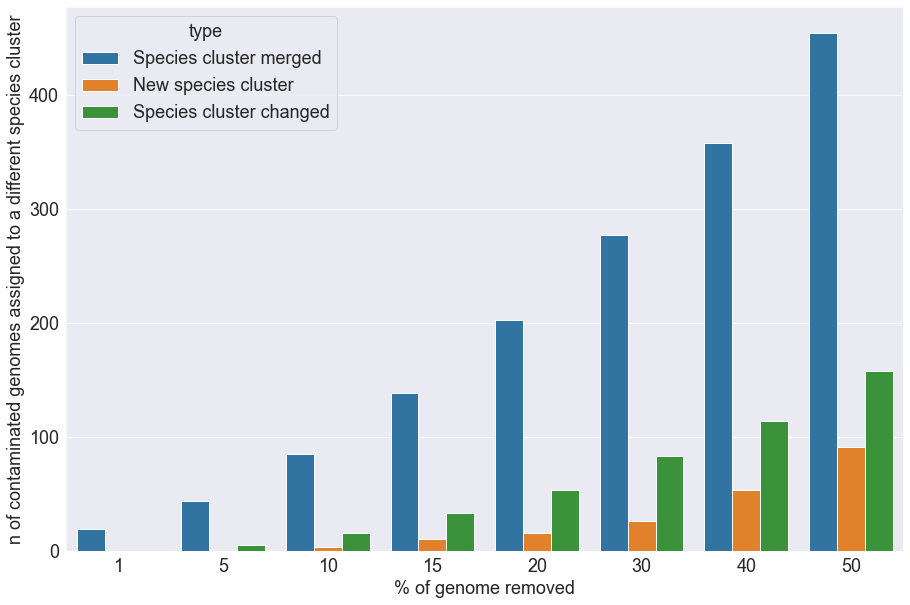

In [13]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
def make_plot():

    rows = list()

    for k, v in data.items():
        cnts = Counter(v)
        rows.append({
            'pct': k,
            'value': cnts.get('representative changed species', 0),
            'type': 'Species cluster merged'
        })
        rows.append({
            'pct': k,
            'value': cnts.get('novel_sp_cluster', 0),
            'type': 'New species cluster'
        })
        rows.append({
            'pct': k,
            'value': cnts.get('species changed', 0),
            'type': 'Species cluster changed'
        })

    df = pd.DataFrame(rows)


    # df = df[df['pct'] <= 10]
    df['value'] = df['value']


    fig, ax = plt.subplots(figsize=(15, 10))

    ax.grid(True)
    plt.rcParams.update({'font.size': 18})
    sns.barplot(data=df, x='pct', y='value', hue='type', ax=ax)
    ax.set_ylabel('n of contaminated genomes assigned to a different species cluster')
    ax.set_xlabel('% of genome removed')

    return



make_plot()